In [13]:
import os
import sys

import tensorflow as tf
from tensorflow import keras
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [9]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [10]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [12]:
dataset = dataset.map(lambda x: x * 2)

In [13]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


## California Housing

In [14]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [15]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [16]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [20]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [60]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [61]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_04.csv', shape=(), dtype=string)
tf.Ten

In [23]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

In [24]:
for line in dataset.take(5):
    print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'


In [62]:
n_inputs = 8

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [63]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [64]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



In [65]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [66]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

In [67]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))

In [68]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 1s 2ms/step - loss: 1.4679 - val_loss: 21.5124
Epoch 2/10
362/362 [==============================] - 1s 2ms/step - loss: 0.8735 - val_loss: 0.6648
Epoch 3/10
362/362 [==============================] - 1s 2ms/step - loss: 0.6317 - val_loss: 0.6196
Epoch 4/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5933 - val_loss: 0.5669
Epoch 5/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5629 - val_loss: 0.5402
Epoch 6/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5693 - val_loss: 0.5209
Epoch 7/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5231 - val_loss: 0.6130
Epoch 8/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5074 - val_loss: 0.4818
Epoch 9/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4963 - val_loss: 0.4904
Epoch 10/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5023 - val_loss: 0.458

In [54]:
model.fit(X_train, y_train, steps_per_epoch=10, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
10/10 [==============================] - 0s 10ms/step - loss: 1268293173248.0000 - val_loss: 1240585732096.0000
Epoch 2/5
10/10 [==============================] - 0s 8ms/step - loss: 1218514255872.0000 - val_loss: 1191895105536.0000
Epoch 3/5
10/10 [==============================] - 0s 8ms/step - loss: 1170688835584.0000 - val_loss: 1145113018368.0000
Epoch 4/5
10/10 [==============================] - 0s 7ms/step - loss: 1124740366336.0000 - val_loss: 1100168036352.0000
Epoch 5/5
10/10 [==============================] - 0s 8ms/step - loss: 1080595447808.0000 - val_loss: 1056989511680.0000


In [59]:
new_set = test_set.map(lambda X, y: X)
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

## TFRecord

In [69]:
with tf.io.TFRecordWriter('my_Data.tfrecord') as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [70]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [71]:
options = tf.io.TFRecordOptions(compression_type='GZIP')
with tf.io.TFRecordWriter('my_compressed.tfrecord', options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [74]:
dataset = tf.data.TFRecordDataset(['my_compressed.tfrecord'],
                                  compression_type='GZIP')
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


## ProtoBuf

In [78]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


In [79]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [80]:
!ls person*

person.desc   person.proto  person_pb2.py


In [81]:
from person_pb2 import Person

In [82]:
person = Person(name="Al", id=123, email=["a@b.com"])
print(person)

name: "Al"
id: 123
email: "a@b.com"



In [87]:
s = person.SerializeToString()
s

b'\n\x02Al\x10{\x1a\x07a@b.com'

In [91]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type='Person',
    field_names=['name', 'id', 'email'],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source='person.desc'
)

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Al'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'a@b.com'], dtype=object)>]

In [93]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

In [95]:
person_example = Example(
    features=Features(
            feature={
                'name':Feature(bytes_list=BytesList(value=[b"Alice"])),
                'id': Feature(int64_list=Int64List(value=[123])),
                'emails': Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
            }))

In [96]:
with tf.io.TFRecordWriter('my_contacts.tfrecord') as f:
    f.write(person_example.SerializeToString())

In [101]:
feature_description = {
    'name': tf.io.FixedLenFeature([], tf.string, default_value=""),
    'id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'emails': tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(['my_contacts.tfrecord']):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [102]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fe5bb00f4d0>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [106]:
parsed_example['emails'].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [107]:
tf.sparse.to_dense(parsed_example['emails'], default_value=b'')

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [108]:
from sklearn.datasets import load_sample_images

In [120]:
img = load_sample_images()['images'][0]

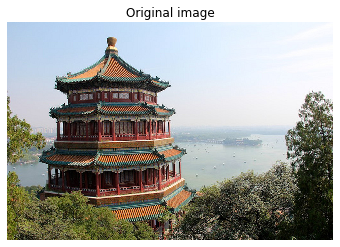

In [121]:
plt.imshow(img)
plt.axis('off')
plt.title('Original image')
plt.show()

In [123]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    'image': Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()

In [124]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image['image'].values[0])

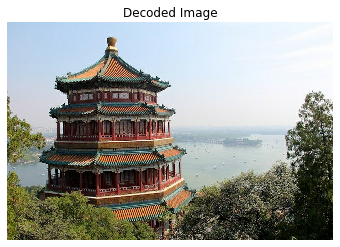

In [125]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

In [126]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [127]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

## The Features API

In [129]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [130]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [131]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [132]:
age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)

In [133]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])

## TF-Transform

In [137]:
import tensorflow_transform as tft

In [138]:
def preprocess(inputs):
    median_age = inputs['housing_media_age']
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        'standardized_median_age': standardized_age,
        'ocean_proximity_id': ocean_proximity_id
    }

## TF Datasets

In [38]:
import tensorflow_datasets as tfds

In [48]:
datasets, datasets_info = tfds.load(name="mnist", with_info=True)
mnist_train, mnist_test = datasets["train"], datasets["test"]

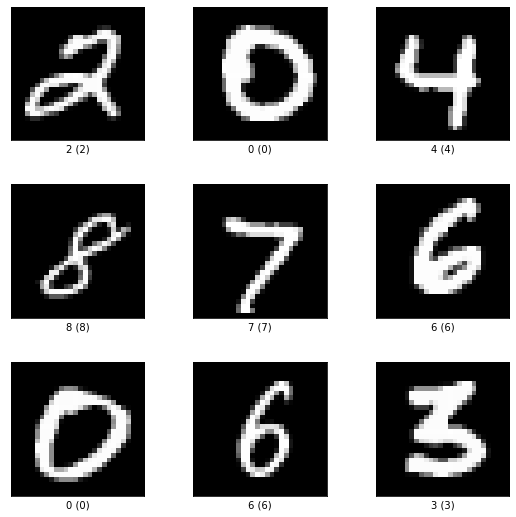

In [50]:
fig = tfds.show_examples(datasets['train'], datasets_info)

In [20]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 32.0989 - accuracy: 0.8421
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 26.0939 - accuracy: 0.8670
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 25.2630 - accuracy: 0.8721A: 1s -
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 24.3679 - accuracy: 0.8762
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 23.8548 - accuracy: 0.8782A: 1s - loss: 23.5740 - accura - ETA: 0s - loss: 23.7674 - accuracy
